# Avito: O que é? 

# Importando libs

In [3]:
%matplotlib inline  
import gc
import re

import numpy as np
import pandas as pd
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


from sentimental import Sentimental

from xgboost import XGBRegressor

from helpers import save_model, load_model, limit_value

[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Carregando o dataset

In [4]:
_train_complete_df = pd.read_csv('train.csv.zip', compression='zip', index_col = "item_id")
train_complete_df = _train_complete_df.copy()

In [5]:
_submission_df = pd.read_csv('test.csv.zip', compression='zip', index_col = "item_id")
submission_df = _submission_df.copy()

In [6]:
train_complete_index = train_complete_df.index
submission_index = submission_df.index

y = train_complete_df['deal_probability'].copy()
train_complete_df.drop("deal_probability",axis=1, inplace=True)

In [7]:
full_df = pd.concat([train_complete_df,submission_df], axis=0)
del train_complete_df, submission_df

In [8]:
def apply_uppercases_and_num_words(df, col_name):
    uppercases = []
    perc_uppercases = []
    total_num_words = []
    for text in df[col_name]:
        text = str(text)
        # remove numeros
        text = re.sub('[0-9]+', '', text)
        
        total_uppers = sum(1 for c in text if c.isupper())
        uppercases.append(total_uppers)
        total = len(text)
        if total == 0:
            perc = 0.0
        else:
            perc = total_uppers/total
        num_words = len(text.split(' '))
        total_num_words.append(num_words)

        perc_uppercases.append(perc)
    
    df[f'perc_uppercases_{col_name}'] = perc_uppercases
    df[f'num_words_{col_name}'] = total_num_words
    return df

In [19]:

def get_sentiments(df, col_name):
    sent = Sentimental()

#     sentiments = [sent.analyze(str(text)) for text in df[col_name].values]
#     scores = [s['comparative'] for s in sentiments]
    scores = [
        sent.analyze(str(text))['comparative'] 
        for text in df[col_name].values
    ]
    df[f'sentiment_{col_name}'] = scores
    return df


In [10]:
full_df['price'] = np.log(full_df['price']+0.001)
full_df['price'].fillna(-999,inplace=True)
full_df['image_top_1'].fillna(-999,inplace=True)

In [11]:
label_encoder = preprocessing.LabelEncoder()
cat_features = [
    'image_top_1',
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1',
    'param_2',
    'param_3',
]
for feature_name in cat_features:
    print(f'encode {feature_name}')
    full_df[feature_name] = label_encoder.fit_transform(full_df[feature_name].astype(str))
    

encode image_top_1
encode city
encode region
encode parent_category_name
encode category_name
encode user_type
encode param_1
encode param_2
encode param_3


In [20]:
full_df = get_sentiments(full_df, 'description')
full_df = get_sentiments(full_df, 'title')

In [15]:
full_df = apply_uppercases_and_num_words(full_df, 'description')
full_df = apply_uppercases_and_num_words(full_df, 'title')

In [23]:
train_complete_df = full_df.loc[train_complete_index,:].copy()
submission_df = full_df.loc[submission_index,:].copy()

In [24]:
del full_df

In [25]:
gc.collect()

33

In [26]:
train_complete_df['deal_probability'] = y

In [27]:
def get_mean_and_freq(df, col_name):
    group = df[[col_name, 'deal_probability']].groupby(col_name)
    freq = (group['deal_probability'].count()/df.shape[0]).to_dict()
    mean = group['deal_probability'].mean().to_dict()
    return mean, freq

def apply_prob_dict_to_col(df_col, prob_dict):
    return df_col.apply(lambda x: prob_dict.get(x, 0.0))


In [28]:
image_top_mean_dict, image_top_freq_dict = get_mean_and_freq(train_complete_df, 'image_top_1')
city_mean_dict, city_freq_dict = get_mean_and_freq(train_complete_df, 'city')

In [29]:
def add_mean_freq_cols_to_df(df, col_name, mean_dict, freq_dict):
    df[f'{col_name}_mean'] = apply_prob_dict_to_col(
        df[col_name], mean_dict
    )
    df[f'{col_name}_freq'] = apply_prob_dict_to_col(
        df[col_name], freq_dict
    )
    return df


In [57]:
for cat_feature in cat_features:
    train_complete_df = add_mean_freq_cols_to_df(
        train_complete_df, cat_feature, image_top_mean_dict, image_top_freq_dict)
    
    submission_df = add_mean_freq_cols_to_df(
        submission_df, cat_feature, city_mean_dict, city_freq_dict)

In [58]:
train_df, test_df = train_test_split(
    train_complete_df, test_size=0.2, random_state=123654)

In [59]:
gc.collect()

441

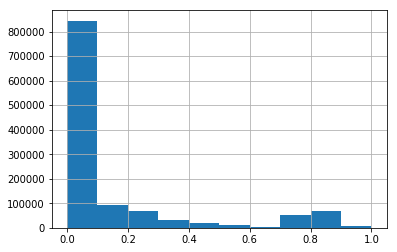

In [60]:
train_df['deal_probability'].hist()


In [114]:
features = [
    'price', 
    'item_seq_number', 
]

features.extend(cat_features)
# features.pop(features.index('param_2'))
# features.pop(features.index('param_3'))
for cat_feat in cat_features:
    features.extend([f'{cat_feat}_{i}' for i in ['mean', 'freq']])
    
features.extend([
    'perc_uppercases_description',
    'perc_uppercases_title',
    'num_words_description',
    'num_words_title',
#     'sentiment_description',
#     'sentiment_title'
])


In [115]:
print(features)

['price', 'item_seq_number', 'image_top_1', 'city', 'region', 'parent_category_name', 'category_name', 'user_type', 'param_1', 'param_2', 'param_3', 'image_top_1_mean', 'image_top_1_freq', 'city_mean', 'city_freq', 'region_mean', 'region_freq', 'parent_category_name_mean', 'parent_category_name_freq', 'category_name_mean', 'category_name_freq', 'user_type_mean', 'user_type_freq', 'param_1_mean', 'param_1_freq', 'param_2_mean', 'param_2_freq', 'param_3_mean', 'param_3_freq', 'perc_uppercases_description', 'perc_uppercases_title', 'num_words_description', 'num_words_title']


## XGBoost Regressor

In [116]:
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgb_reg = XGBRegressor(reg_lambda=0, n_jobs=6)  

# cv_params = {
#     'min_child_weight': 1,
#     'max_depth': 3,
    
# }


In [117]:
gs = RandomizedSearchCV(xgb_reg, params, n_jobs=1)  
gs.fit(train_df[features], train_df['deal_probability']) 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efcd60a7470>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efcd60a73c8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efcd60a76d8>, 'colsample_bytree...0a3e80>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efcd60a3e80>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
         

In [118]:
print(gs.best_score_)

0.23151958040782347


In [119]:
print(gs.best_score_)

0.23151958040782347


In [120]:
xgb_reg_best = gs.best_estimator_

In [121]:
xgb_reg_best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9412332640753721, gamma=3.27096825045332,
       learning_rate=0.42538154338476014, max_delta_step=0, max_depth=22,
       min_child_weight=1.757354797029547, missing=None, n_estimators=28,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=12.695675287629834, reg_lambda=0, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.95161753418512)

In [97]:
# salvando o modelo
save_model('xgb_sentiment_reg_best_rsCV.pkl', xgb_reg_best)

## Usando o Modelo do XGBoost gerado

In [122]:
y_test_predict = xgb_reg_best.predict(test_df[features])

y_test_predict_treated = np.array(list(map(limit_value, y_test_predict)))


### new_error

In [123]:
print(mean_squared_error(test_df['deal_probability'], y_test_predict))
print(mean_squared_error(test_df['deal_probability'], y_test_predict_treated))

0.05166833129749927
0.05166652087569351


### last error

In [109]:
print(mean_squared_error(test_df['deal_probability'], y_test_predict))
print(mean_squared_error(test_df['deal_probability'], y_test_predict_treated))

0.05322120524435099
0.053221191225261234


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efcd6047128>,
      dtype=object)

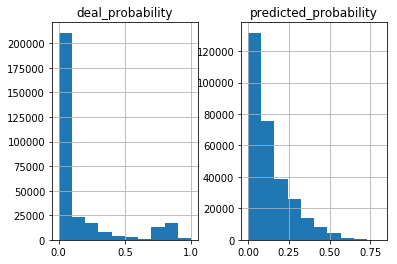

In [124]:
prediction_test_df = pd.DataFrame(
    {'predicted_probability': y_test_predict_treated, 'deal_probability': test_df['deal_probability']}, 
    index=test_df.index
)
prediction_test_df[['predicted_probability', 'deal_probability']].hist()

In [125]:
prediction_test_df.describe()

,predicted_probability,deal_probability
count,300685.000000,300685.000000
mean,0.139261,0.139493
std,0.124269,0.260449
min,0.000000,0.000000
25%,0.048108,0.000000
50%,0.095317,0.000000
75%,0.196387,0.151780
max,0.810388,1.000000


In [126]:
y_submission_predict = xgb_reg_best.predict(submission_df[features])

In [127]:
y_submission_predict_treated = np.array(list(map(limit_value, y_submission_predict)))

In [128]:
submission_prediction_df = pd.DataFrame(
    {'deal_probability': y_submission_predict_treated}, 
    index=submission_df.index)
submission_prediction_df['deal_probability'].describe()

count    508438.000000
mean          0.076801
std           0.063140
min           0.000000
25%           0.030932
50%           0.064171
75%           0.097931
max           0.642925
Name: deal_probability, dtype: float64

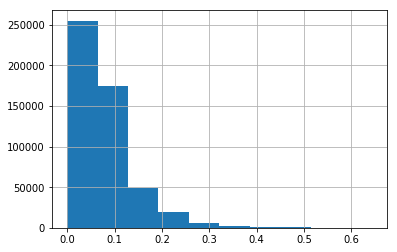

In [129]:
submission_prediction_df['deal_probability'].hist()

In [95]:
assert submission_prediction_df['deal_probability'].min() >= 0
assert submission_prediction_df['deal_probability'].shape[0] == 508438

In [96]:
submission_prediction_df.to_csv('submission_xgb_perc_uppercases_nwords_sentiment_desc_title_and_all_features_no_prob.csv')